## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import pickle
from mlxtend.data import loadlocal_mnist
import random

## Setting Numpy Seed

In [2]:
np.random.seed(10)

## Processing MNIST Dataset

In [3]:
def process_mnist_data() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    mnist_path = './MNIST/'
    train_images, train_labels = loadlocal_mnist(
        images_path = mnist_path + './train-images.idx3-ubyte',
        labels_path = mnist_path + './train-labels.idx1-ubyte'
    )
    test_images, test_labels = loadlocal_mnist(
        images_path = mnist_path + './t10k-images.idx3-ubyte',
        labels_path = mnist_path + './t10k-labels.idx1-ubyte'
    )
    return train_images, train_labels, test_images, test_labels

## Processing CIFAR-10 Dataset

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

In [5]:
def process_cifar_dataset() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    cifar_path = './cifar-10-python/cifar-10-batches-py'
    data_batch = unpickle(cifar_path + '/data_batch_1')
    train_images, train_labels = data_batch[b'data'], np.array(data_batch[b'labels'])
    for i in range(2,6):
        data_batch = unpickle(cifar_path + '/data_batch_' + str(i))
        train_images = np.concatenate((train_images, data_batch[b'data']), axis=0)
        train_labels = np.concatenate((train_labels, np.array(data_batch[b'labels'])), axis=0)
    test_batch = unpickle(cifar_path + '/test_batch')
    test_images, test_labels = test_batch[b'data'], np.array(test_batch[b'labels'])
    return train_images, train_labels, test_images, test_labels

## Processing Toy Dataset

In [6]:
def process_toy_dataset():
    toy_dataset_path = './Toy Dataset/'
    a = np.loadtxt(toy_dataset_path + 'trainNN.txt')
    b = np.loadtxt(toy_dataset_path + 'testNN.txt')
    train_x, train_y, test_x, test_y = a[:, 0:4], a[:, -1], b[:, 0:4], b[:, -1]
    return train_x, train_y, test_x, test_y

In [7]:
x_train_toy, y_train_toy, x_test_toy, y_test_toy = process_toy_dataset()
toy_batch_1 = x_train_toy[0:50].reshape(50, 1, 2, 2)
toy_batch_1[0, 0, :, :]

array([[ 9.21323266, 11.82445528],
       [16.69098092, 19.56967227]])

In [8]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(1,5))
toy_labels_1 = label_binarizer.transform(y_train_toy[0:50].T)
toy_labels_1

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1,

## Parsing Input Model

In [9]:
def parse_input_model():
    path = './input_model.txt'
    model = []
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            if tokens[0] == 'Conv':
                model.append(ConvolutionLayerBatch(int(tokens[1]), int(tokens[2]), int(tokens[3]), int(tokens[4])))
            if tokens[0] == 'ReLU':
                model.append(ActivationLayer())
            if tokens[0] == 'Pool':
                model.append(MaxPoolingLayerBatch(int(tokens[1]), int(tokens[2])))
            if tokens[0] == 'FC':
                model.append(FlatteningLayerBatch())
                model.append(FullyConnectedLayerBatch(int(tokens[1])))
            if tokens[0] == 'Softmax':
                model.append(SoftmaxLayerBatch())
        return model

## ReLU and ReLU Derivative Functions

In [10]:
def relu(matrix:np.ndarray) -> np.ndarray:
    return matrix * (matrix > 0)

In [11]:
x = np.random.randint(-1, 10, (2, 2))
x

array([[ 8,  3],
       [-1,  0]])

In [12]:
def relu_derivative(matrix: np.ndarray) -> np.ndarray:
    return (matrix > 0).astype(np.int32)

## Convolution Layer

In [13]:
class ConvolutionLayer:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding

    def forward(self, input_image: np.ndarray) -> np.ndarray:
        input_dimentions = input_image.shape[0]
        output_dimentions = (input_dimentions - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_image.shape

        filters = np.random.rand(
            self.output_channel_count,
            self.filter_dimension,
            self.filter_dimension,
            input_shape[2]
        )

        bias = np.random.rand(self.output_channel_count)

        padded_image = np.pad(input_image, [(self.padding,self.padding), (self.padding,self.padding), (0,0)], mode='constant') * 1.0
        # padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((output_dimentions, output_dimentions, self.output_channel_count))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= padded_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= padded_dimensions[0]:
                image_slice = padded_image[image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.sum(image_slice * filters) + bias
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [14]:
class ConvolutionLayerBatch:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding
        self.bias = None
        self.filters = None
        self.input_batch = None

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        self.input_batch = input_batch

        input_dimentions = input_batch.shape
        output_dimentions = (input_dimentions[2] - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_batch.shape

        if self.filters is None:
            self.filters = np.random.randn(
                self.output_channel_count,
                input_shape[1],
                self.filter_dimension,
                self.filter_dimension
            ) * np.sqrt(2/input_shape[1] * self.filter_dimension ** 2)

        # if self.filters is None:
        #     self.filters = np.random.randn(
        #         self.output_channel_count,
        #         input_shape[1],
        #         self.filter_dimension,
        #         self.filter_dimension
        #     ) * 0.01

        if self.bias is None:
            self.bias = np.zeros(self.output_channel_count)

        padded_image = np.pad(input_batch, [(0, 0), (0, 0), (self.padding,self.padding), (self.padding,self.padding)], mode='constant') * 1.0
        padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((input_dimentions[0], self.output_channel_count, output_dimentions, output_dimentions))

        for i in range(input_dimentions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= padded_dimensions[3]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= padded_dimensions[2]:
                    image_slice = padded_image[i, :, image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension]
                    output[i, :, out_x, out_y] = np.sum(image_slice * self.filters) + self.bias
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self, dz: np.ndarray, learning_rate:float = 1e-3) -> np.ndarray:
        batch_size = dz.shape[0]
        db = np.sum(dz, axis=(0, 2, 3))
        self.bias = self.bias - learning_rate * db / batch_size
        padded_image = np.pad(self.input_batch, [(0, 0), (0, 0), (self.padding,self.padding), (self.padding,self.padding)], mode='constant') * 1.0
        padded_dimensions = padded_image.shape

        dw = np.zeros(self.filters.shape)
        dz_prime_dim = (dz.shape[2] - 1) * self.stride + 1
        dz_prime = np.zeros((dz.shape[0], dz.shape[1], dz_prime_dim, dz_prime_dim))
        dz_prime[:, :, ::self.stride, ::self.stride] = dz

        # calculate dw
        for i in range(padded_dimensions[0]):
            image_y = out_y = 0
            while image_y + dz_prime_dim <= padded_dimensions[3]:
                image_x = out_x = 0
                while image_x + dz_prime_dim <= padded_dimensions[2]:
                    image_slice = padded_image[i, :, image_x:image_x+dz_prime_dim, image_y:image_y+dz_prime_dim]
                    dz_slice = dz_prime[i, :, :, :]
                    dz_slice_shape = dz_slice.shape
                    dz_slice = np.broadcast_to(dz_slice, (image_slice.shape[0], dz_slice_shape[0], dz_slice_shape[1], dz_slice_shape[2])).transpose((1, 0, 2, 3))
                    dw[:, :, out_x, out_y] += np.sum(image_slice * dz_slice, axis=(2, 3))
                    image_x += 1
                    out_x += 1
                image_y += 1
                out_y += 1

        rotated_filter = np.rot90(self.filters, 2, axes=(2, 3))
        dx = np.zeros(self.input_batch.shape)
        padding = self.filter_dimension - 1 - self.padding
        if padding < 0:
            dz_prime_padded = dz_prime[:, :, -padding:padding, -padding:padding]
        else:
            dz_prime_padded = np.pad(dz_prime, [(0, 0), (0, 0), (padding, padding), (padding, padding)], mode='constant')

        dz_padded_dimensions = dz_prime_padded.shape

        # calculate dx
        for i in range(dz_padded_dimensions[0]):
            dz_y = out_y = 0
            while dz_y + self.filter_dimension <= dz_padded_dimensions[3]:
                dz_x = out_x = 0
                while dz_x + self.filter_dimension <= dz_padded_dimensions[2]:
                    dzp_slice = dz_prime_padded[i, :, dz_x:dz_x+self.filter_dimension, dz_y:dz_y+self.filter_dimension]
                    dzp_slice = dzp_slice.reshape(dz_padded_dimensions[1], 1, self.filter_dimension, self.filter_dimension)
                    dx[i, :, out_x, out_y] = np.sum(dzp_slice * rotated_filter, axis=(0, 2, 3))
                    dz_x += 1
                    out_x += 1
                dz_y += 1
                out_y += 1

        self.filters -= learning_rate * dw / batch_size
        return dx

In [15]:
test_conv = ConvolutionLayerBatch(4, 2, 2, 2)
test_conv_out = test_conv.forward(toy_batch_1)
test_conv_out.shape

(50, 4, 3, 3)

In [16]:
test_conv_out[0, 0, :, :]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.94339174, 0.        ],
       [0.        , 0.        , 0.        ]])

## Activation Layer

In [17]:
class ActivationLayer:
    def __init__(self):
        self.input_batch = None

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        self.input_batch = input_matrix
        return relu(input_matrix)

    def backward(self, input_matrix: np.ndarray) -> np.ndarray:
        return input_matrix * relu_derivative(self.input_batch)

In [18]:
test_activation = ActivationLayer()
test_activation_out = test_activation.forward(test_conv_out)
test_activation_out.shape

(50, 4, 3, 3)

In [19]:
test_activation_out[0, 0, :, :]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.94339174, 0.        ],
       [0.        , 0.        , 0.        ]])

## Max Pooling Layer

In [20]:
class MaxPoolingLayer:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        output_dimension = (input_dimensions[0] - self.filter_dimension) // self.stride + 1

        output = np.zeros((output_dimension, output_dimension, input_dimensions[2]))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= input_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= input_dimensions[0]:
                image_slice = image[image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.max(image_slice, axis=(0, 1))
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [21]:
class MaxPoolingLayerBatch:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.mask = None
        self.input_dimensions = None

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        self.input_dimensions = input_dimensions
        output_dimension = (input_dimensions[2] - self.filter_dimension) // self.stride + 1

        output = np.zeros((input_dimensions[0], input_dimensions[1], output_dimension, output_dimension))
        self.mask = np.zeros(input_dimensions)

        for i in range(input_dimensions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= input_dimensions[3]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= input_dimensions[2]:
                    image_slice = image[i, :, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension]
                    max_val = np.max(image_slice, axis=(1, 2))
                    output[i, :, out_x, out_y] = max_val
                    self.mask[i, :, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension] = image_slice == max_val.reshape(input_dimensions[1], 1, 1)
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self, dh:np.ndarray) -> np.ndarray:
        output = np.zeros(self.input_dimensions)

        for i in range(self.input_dimensions[0]):
            out_y = dh_y = 0
            while out_y + self.filter_dimension <= self.input_dimensions[3]:
                out_x = dh_x = 0
                while out_x + self.filter_dimension <= self.input_dimensions[2]:
                    mask_patch = self.mask[i, :, out_x: out_x+self.filter_dimension, out_y: out_y+self.filter_dimension]
                    output[i, :, out_x: out_x+self.filter_dimension, out_y: out_y+self.filter_dimension] += mask_patch * dh[i, :, dh_x, dh_y].reshape(self.input_dimensions[1], 1, 1)
                    out_x += self.stride
                    dh_x += 1
                out_y += self.stride
                dh_y += 1

        return output

In [22]:
test_maxpool = MaxPoolingLayerBatch(2, 1)
test_maxpool_out = test_maxpool.forward(test_activation_out)
test_maxpool_out.shape

(50, 4, 2, 2)

In [23]:
test_maxpool_out[0, 0, :, :]

array([[0.94339174, 0.94339174],
       [0.94339174, 0.94339174]])

## Flattening Layer

In [24]:
class FlatteningLayer:
    def __init__(self):
        pass

    @staticmethod
    def forward(image: np.ndarray) -> np.ndarray:
        return image.flatten().reshape(-1, 1)

    def backward(self):
        pass

In [25]:
class FlatteningLayerBatch:
    def __init__(self):
        self.input_shape = None

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        input_shape = input_batch.shape
        self.input_shape = input_shape
        return input_batch.reshape((input_shape[0], -1))

    def backward(self, dh_flattened: np.ndarray) -> np.ndarray:
        return dh_flattened.reshape(self.input_shape)

In [26]:
test_flattening = FlatteningLayerBatch()
test_flattening_out = test_flattening.forward(test_maxpool_out)
test_flattening_out.shape

(50, 16)

In [27]:
test_flattening_out

array([[0.94339174, 0.94339174, 0.94339174, 0.94339174, 0.94339174,
        0.94339174, 0.94339174, 0.94339174, 0.94339174, 0.94339174,
        0.94339174, 0.94339174, 0.94339174, 0.94339174, 0.94339174,
        0.94339174],
       [1.85173385, 1.85173385, 1.85173385, 1.85173385, 1.85173385,
        1.85173385, 1.85173385, 1.85173385, 1.85173385, 1.85173385,
        1.85173385, 1.85173385, 1.85173385, 1.85173385, 1.85173385,
        1.85173385],
       [3.69483751, 3.69483751, 3.69483751, 3.69483751, 3.69483751,
        3.69483751, 3.69483751, 3.69483751, 3.69483751, 3.69483751,
        3.69483751, 3.69483751, 3.69483751, 3.69483751, 3.69483751,
        3.69483751],
       [2.78262626, 2.78262626, 2.78262626, 2.78262626, 2.78262626,
        2.78262626, 2.78262626, 2.78262626, 2.78262626, 2.78262626,
        2.78262626, 2.78262626, 2.78262626, 2.78262626, 2.78262626,
        2.78262626],
       [3.70786021, 3.70786021, 3.70786021, 3.70786021, 3.70786021,
        3.70786021, 3.70786021, 

## Fully Connected Layer

In [28]:
class FullyConnectedLayer:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        weights = np.random.rand(flattened_input.shape[0], self.output_dimension)
        bias = np.random.rand(self.output_dimension, 1)

        return weights.T @ flattened_input + bias

    def backward(self):
        pass

In [29]:
class FullyConnectedLayerBatch:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension
        self.input_matrix = None
        self.weights = None
        self.bias = None

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        if self.weights is None:
            self.weights = np.random.randn(flattened_input.shape[1], self.output_dimension) * np.sqrt(2/flattened_input.shape[1])
            # self.weights = np.random.randn(flattened_input.shape[1], self.output_dimension) * 0.01
        if self.bias is None:
            self.bias = np.zeros((1, self.output_dimension))
        self.input_matrix = flattened_input

        return flattened_input @ self.weights + self.bias

    def backward(self, d_theta: np.ndarray, learning_rate: float = 1e-3) -> np.ndarray:
        n = d_theta.shape[0]
        dw = self.input_matrix.T @ d_theta
        db = np.sum(d_theta, axis=0, keepdims=True)
        dh = d_theta @ self.weights.T
        self.weights = self.weights - learning_rate * dw / n
        self.bias = self.bias - learning_rate * db / n

        return dh

In [30]:
test_fc = FullyConnectedLayerBatch(4)
test_fc_out = test_fc.forward(test_flattening_out)
test_fc_out.shape

(50, 4)

In [31]:
test_fc_out

array([[-0.00278571, -0.13054229,  0.04797275,  0.1314437 ],
       [-0.00546792, -0.25623457,  0.09416318,  0.25800389],
       [-0.01091036, -0.51127494,  0.1878875 ,  0.51480534],
       [-0.00821672, -0.38504726,  0.14150032,  0.38770605],
       [-0.01094881, -0.51307696,  0.18854972,  0.5166198 ],
       [-0.00543533, -0.25470716,  0.09360187,  0.25646594],
       [-0.00270517, -0.12676832,  0.04658586,  0.12764366],
       [-0.00830489, -0.38917901,  0.14301869,  0.39186633],
       [-0.00273351, -0.12809611,  0.04707381,  0.12898062],
       [-0.00819846, -0.38419139,  0.1411858 ,  0.38684426],
       [-0.00820249, -0.38438047,  0.14125528,  0.38703465],
       [-0.00822341, -0.38536083,  0.14161555,  0.38802178],
       [-0.00828809, -0.38839158,  0.14272932,  0.39107346],
       [-0.00536763, -0.25153485,  0.09243609,  0.25327172],
       [-0.00268126, -0.12564754,  0.04617399,  0.12651515],
       [-0.00544366, -0.25509779,  0.09374543,  0.25685926],
       [-0.00271945, -0.

## Softmax Layer

In [32]:
class SoftmaxLayer:
    def __init__(self):
        pass

    @staticmethod
    def forward(input_matrix: np.ndarray) -> np.ndarray:
        exp = np.exp(input_matrix)
        exp /= np.sum(exp)
        return exp

    def backward(self):
        pass

In [33]:
class SoftmaxLayerBatch:
    def __init__(self):
        self.y_hat = None

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        input_matrix -= np.max(input_matrix)
        exp = np.exp(input_matrix)
        exp_sum = np.sum(exp, axis=1).reshape(-1, 1)
        exp /= exp_sum
        self.y_hat = exp
        return exp

    def backward(self, y: np.ndarray) -> np.ndarray:
        return self.y_hat - y

In [34]:
test_softmax = SoftmaxLayerBatch()
test_softmax_out = test_softmax.forward(test_fc_out)
test_softmax_out.shape

(50, 4)

In [35]:
test_softmax_out

array([[0.24535112, 0.21592557, 0.25812624, 0.28059707],
       [0.23898244, 0.18597708, 0.26401903, 0.31102145],
       [0.22134109, 0.13420122, 0.27002181, 0.37443588],
       [0.23077141, 0.15831664, 0.26804227, 0.34286968],
       [0.22119792, 0.1338781 , 0.2700363 , 0.37488768],
       [0.23907009, 0.1863236 , 0.26395905, 0.31064726],
       [0.2455147 , 0.21686905, 0.25791959, 0.27969666],
       [0.23048288, 0.15748063, 0.26813757, 0.34389893],
       [0.24545734, 0.21653681, 0.25799249, 0.28001336],
       [0.23083099, 0.15849022, 0.26802227, 0.34265652],
       [0.23081784, 0.15845186, 0.2680267 , 0.34270361],
       [0.23074956, 0.15825309, 0.26804958, 0.34294777],
       [0.23053798, 0.15763971, 0.26811957, 0.34370274],
       [0.23925137, 0.18704468, 0.26383356, 0.30987039],
       [0.24556296, 0.21714972, 0.25785789, 0.27942943],
       [0.2390477 , 0.18623494, 0.26397442, 0.31074295],
       [0.24548583, 0.21670161, 0.25795635, 0.27985621],
       [0.23073435, 0.15820885,

## Backprop Test

#### Loss Function

In [36]:
def loss_function(y_true, y_pred):
    labels = y_true * np.log(y_pred) * -1.0
    return np.sum(labels) / y_true.shape[0]

In [37]:
loss_function_test = loss_function(toy_labels_1, test_softmax_out)
loss_function_test

1.308813541231649

#### Softmax Layer

In [38]:
test_softmax_back = test_softmax.backward(toy_labels_1)
print(test_softmax_back.shape)
test_softmax_back

(50, 4)


array([[-0.75464888,  0.21592557,  0.25812624,  0.28059707],
       [ 0.23898244, -0.81402292,  0.26401903,  0.31102145],
       [ 0.22134109,  0.13420122,  0.27002181, -0.62556412],
       [ 0.23077141,  0.15831664, -0.73195773,  0.34286968],
       [ 0.22119792,  0.1338781 ,  0.2700363 , -0.62511232],
       [ 0.23907009, -0.8136764 ,  0.26395905,  0.31064726],
       [-0.7544853 ,  0.21686905,  0.25791959,  0.27969666],
       [ 0.23048288,  0.15748063, -0.73186243,  0.34389893],
       [-0.75454266,  0.21653681,  0.25799249,  0.28001336],
       [ 0.23083099,  0.15849022, -0.73197773,  0.34265652],
       [ 0.23081784,  0.15845186, -0.7319733 ,  0.34270361],
       [ 0.23074956,  0.15825309, -0.73195042,  0.34294777],
       [ 0.23053798,  0.15763971, -0.73188043,  0.34370274],
       [ 0.23925137, -0.81295532,  0.26383356,  0.30987039],
       [-0.75443704,  0.21714972,  0.25785789,  0.27942943],
       [ 0.2390477 , -0.81376506,  0.26397442,  0.31074295],
       [-0.75451417,  0.

#### Fully Connected Layer

In [39]:
test_fc_back = test_fc.backward(test_softmax_back, learning_rate=0.01)
print(test_fc_back.shape)
test_fc_back

(50, 16)


array([[ 1.48398111e-01, -4.00215037e-01, -2.18462332e-01,
         4.68962041e-02, -4.49048247e-02,  2.02109211e-01,
         3.37565231e-03,  1.12917608e-01, -1.68423022e-01,
         5.72480166e-02, -4.08124047e-02,  5.47060433e-01,
        -3.25673935e-01,  3.29883463e-02,  4.18397047e-01,
        -3.46327567e-01],
       [ 4.04812354e-01,  7.15113212e-01,  7.50546247e-02,
        -7.41437308e-02, -5.36685405e-01, -2.66817536e-01,
        -4.03044846e-01,  3.74228888e-01,  5.81652425e-01,
        -1.54708783e-01,  1.98329516e-02, -3.99784709e-01,
         8.33220567e-01,  9.10672596e-02, -8.88087519e-01,
        -2.03013967e-01],
       [-5.54869592e-01,  2.69185792e-01,  1.93421191e-01,
        -4.78794955e-02,  1.20880216e-03, -2.89522795e-01,
         2.24074043e-01,  8.30975898e-02, -2.20382552e-01,
        -4.72494402e-02, -1.62007463e-01, -7.83851735e-02,
         2.38559206e-01,  2.58231151e-01,  4.98057447e-02,
        -9.94024537e-03],
       [ 3.10334217e-01, -4.40869335e

#### Flattening Layer

In [40]:
test_flattening_back = test_flattening.backward(test_fc_back)
test_flattening_back[0, 0, :, :]

array([[ 0.14839811, -0.40021504],
       [-0.21846233,  0.0468962 ]])

#### MaxPooling Layer

In [41]:
test_maxpool_back = test_maxpool.backward(test_flattening_back)
test_flattening_back.shape

(50, 4, 2, 2)

In [42]:
test_maxpool_back[0, 0, :, :]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.42338305,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

#### Activation Layer

In [43]:
test_activation_back = test_activation.backward(test_maxpool_back)
test_activation_back.shape

(50, 4, 3, 3)

In [44]:
test_activation_back[0, 0, :, :]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.42338305,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

#### Convolution Layer

In [45]:
test_conv_back = test_conv.backward(test_activation_back, learning_rate=0.01)
test_conv_back.shape

(50, 1, 2, 2)

In [46]:
test_conv_back[0, 0, :, :]

array([[ 0.74448892, -1.39867239],
       [ 2.44351392,  0.00654209]])

#### Predictiona and Accuracy

In [47]:
def measure_accuracy(y_true, y_pred):
    accurate = np.sum(np.all(y_true == y_pred, axis=1))
    total = y_true.shape[0]
    return accurate / total

In [48]:
def predict_labels(a):
    return (a == a.max(axis=1)[:,None]).astype(int)

## Main Test

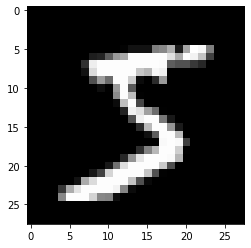

In [49]:
x_train, y_train, x_test, y_test = process_mnist_data()
img = x_train[0].reshape(28, 28, 1)
plt.imshow(img, cmap='gray')

## Mnist Dataset Train-test

In [50]:
model = parse_input_model()

In [51]:
# train
random_index = random.sample(range(0, 60000), 1280)
mnist_subsample_x = x_train[random_index]
mnist_subsample_y = y_train[random_index]
# validation
mnist_validation_x = x_test[:200]
mnist_validation_y = y_test[:200]
# test
mnist_test_x = x_test[5001:7001]
mnist_test_y = y_test[5001:7001]

In [52]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(0,10))

LabelBinarizer()

In [53]:
validation_batch = mnist_validation_x.reshape(200, 1, 28, 28) / 255.0
validation_labels = label_binarizer.transform(mnist_validation_y)

In [54]:
validation_labels[0:100]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0,

In [55]:
test_batch = mnist_test_x.reshape(2000, 1, 28, 28)
test_labels = label_binarizer.transform(mnist_test_y)

In [56]:
# %%timeit
# inp = mnist_batch_1
# for layer in model:
#     inp = layer.forward(inp)
#
# labels_true = label_binarizer.transform(mnist_labels_1)
# l = loss_function(labels_true, inp)
#
# out = labels_true
# for layer in reversed(model):
#     out = layer.backward(out)

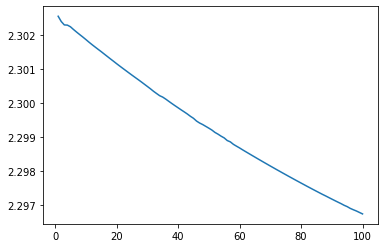

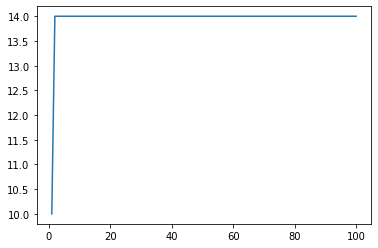

In [57]:
validation_losses = []
validation_accuracy = []
validation_index = [i for i in range(1,101)]
for i in range(100):
    # losses = []
    # index = [i for i in range(1,157)]
    for j in range(0, 1280, 32):
        batch_x = mnist_subsample_x[j:j+32].reshape(32, 1, 28, 28).astype(np.float64)
        batch_x /= 255.0
        batch_y = mnist_subsample_y[j:j+32]
        model_out = batch_x
        # train
        for layer in model:
            # print(layer)
            model_out = layer.forward(model_out)
            # print(model_out.shape)

        true_labels = label_binarizer.transform(batch_y)
        l = loss_function(true_labels, model_out)
        # losses.append(l)
        # print("Epoc {} batch {} loss = {}".format(i, j//32, l))


        model_back = true_labels
        for layer in reversed(model):
            # print(layer)
            model_back = layer.backward(model_back)
            # print(model_back.shape)

    # plt.plot(index, losses)
    # plt.show()

    #validation
    validation_out = validation_batch
    for layer in model:
        validation_out = layer.forward(validation_out)
    validation_loss = loss_function(validation_labels, validation_out)
    validation_losses.append(validation_loss)
    # print('Validation loss after epoc {} is {}'.format(i, validation_loss))
    validation_predictions = predict_labels(validation_out)
    accuracy = measure_accuracy(validation_labels, validation_predictions)
    validation_accuracy.append(accuracy * 100)
    # print('Validation accuracy after epoc {} is {}'.format(i, accuracy))

plt.plot(validation_index, validation_losses)
plt.show()
plt.plot(validation_index, validation_accuracy)
plt.show()

## Toy Dataset Train-test

In [58]:
# label_binarizer_toy = LabelBinarizer()
# label_binarizer_toy.fit(range(1,5))

In [59]:
# toy_model = [FullyConnectedLayerBatch(4), SoftmaxLayerBatch()]
# x_train, y_train, x_test, y_test = process_toy_dataset()
# x_validation, y_validation = x_test[:250], y_test[:250]
# x_test, y_test = x_test[250:], y_test[250:]

In [60]:
# y_validation = label_binarizer_toy.transform(y_validation)
# y_test = label_binarizer_toy.transform(y_test)

In [61]:
# validation_losses = []
# validation_accuracy = []
# validation_index = [i for i in range(1,12001)]
# for i in range(12000):
#     losses = []
#     index = [i for i in range(1,21)]
#     for j in range(0, 500, 25):
#         batch_x = x_train[j:j+25]
#         batch_y = y_train[j:j+25]
#         model_out = batch_x
#         # train
#         for layer in toy_model:
#             model_out = layer.forward(model_out)
#
#         true_labels = label_binarizer_toy.transform(batch_y)
#         l = loss_function(true_labels, model_out)
#         losses.append(l)
#
#         model_back_toy = true_labels
#         for layer in reversed(toy_model):
#             model_back_toy = layer.backward(model_back_toy)
#
#     #validation
#     validation_out = x_validation
#     for layer in toy_model:
#         validation_out = layer.forward(validation_out)
#     validation_loss = loss_function(y_validation, validation_out)
#     validation_losses.append(validation_loss)
#     validation_predictions = predict_labels(validation_out)
#     accuracy = measure_accuracy(y_validation, validation_predictions)
#     validation_accuracy.append(accuracy*100)
#
# # print(validation_losses)
# plt.plot(validation_index, validation_losses)
# plt.show()
# plt.plot(validation_index, validation_accuracy)
# plt.show()

In [62]:
# test_out = x_test
# for layer in toy_model:
#     test_out = layer.forward(test_out)
# test_prediction = predict_labels(test_out)
# accuracy = measure_accuracy(y_test, test_prediction)
# accuracy